<a href="https://colab.research.google.com/github/KwonHo-geun/automobile/blob/main/25.07.15_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 📦 Google Colab용 ImageNet 1000개 클래스 분류기
# 🧠 사전 훈련된 딥러닝 모델로 즉시 객체 인식!

# 필요한 라이브러리 설치 및 임포트
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from io import BytesIO
import cv2

print("✅ 라이브러리 로드 완료!")
print(f"🔥 PyTorch 버전: {torch.__version__}")
print(f"💻 CUDA 사용 가능: {torch.cuda.is_available()}")

✅ 라이브러리 로드 완료!
🔥 PyTorch 버전: 2.6.0+cu124
💻 CUDA 사용 가능: False


In [3]:
class ImageNetClassifier:
    """ImageNet 사전 훈련된 모델을 사용한 1000개 클래스 분류기"""

    def __init__(self, model_name='resnet50'):
        print(f"🧠 {model_name} 모델 로딩 중...")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"💻 사용 디바이스: {self.device}")

        # 모델 로드
        self.model = self.load_model(model_name)
        self.model.eval()  # 평가 모드

        # ImageNet 클래스 라벨 로드
        self.class_labels = self.load_imagenet_labels()

        # 이미지 전처리 설정
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        print(f"✅ {model_name} 모델 준비 완료!")
        print(f"📊 분류 가능한 클래스: 1000개")

    def load_model(self, model_name):
        """사전 훈련된 모델 로드"""
        models_dict = {
            'resnet50': models.resnet50(pretrained=True),
            'resnet101': models.resnet101(pretrained=True),
            'vgg16': models.vgg16(pretrained=True),
            'vgg19': models.vgg19(pretrained=True),
            'densenet121': models.densenet121(pretrained=True),
            'efficientnet_b0': models.efficientnet_b0(pretrained=True),
            'mobilenet_v2': models.mobilenet_v2(pretrained=True),
            'alexnet': models.alexnet(pretrained=True),
            'inception_v3': models.inception_v3(pretrained=True)
        }

        if model_name not in models_dict:
            print(f"⚠️ {model_name} 모델을 찾을 수 없습니다. ResNet50을 사용합니다.")
            model_name = 'resnet50'

        model = models_dict[model_name]
        return model.to(self.device)

    def load_imagenet_labels(self):
        """ImageNet 1000개 클래스 라벨 로드"""
        try:
            # ImageNet 클래스 라벨 다운로드
            url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
            response = requests.get(url)
            labels = response.text.strip().split('\n')
            print(f"📋 ImageNet 라벨 로드 완료: {len(labels)}개")
            return labels
        except:
            print("⚠️ 온라인 라벨 로드 실패. 기본 라벨을 사용합니다.")
            # 일부 주요 클래스만 포함한 기본 라벨
            return [f"class_{i}" for i in range(1000)]

    def load_image(self, image_source):
        """이미지 로드 (파일 경로 또는 URL)"""
        try:
            if isinstance(image_source, str):
                if image_source.startswith('http'):
                    # URL에서 이미지 다운로드
                    response = requests.get(image_source)
                    image = Image.open(BytesIO(response.content)).convert('RGB')
                else:
                    # 로컬 파일
                    image = Image.open(image_source).convert('RGB')
            else:
                # PIL Image 객체
                image = image_source.convert('RGB')

            return image
        except Exception as e:
            print(f"❌ 이미지 로드 실패: {e}")
            return None

    def preprocess_image(self, image):
        """이미지 전처리"""
        if image is None:
            return None

        # PIL Image → Tensor
        tensor = self.transform(image).unsqueeze(0)  # 배치 차원 추가
        return tensor.to(self.device)

    def predict(self, image_source, top_k=5):
        """이미지 분류 예측"""
        print(f"🔍 이미지 분석 중...")

        # 이미지 로드
        image = self.load_image(image_source)
        if image is None:
            return None

        original_image = image.copy()

        # 전처리
        input_tensor = self.preprocess_image(image)
        if input_tensor is None:
            return None

        # 예측
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # Top-K 결과 추출
        top_prob, top_indices = torch.topk(probabilities, top_k)

        results = []
        for i in range(top_k):
            class_idx = top_indices[i].item()
            prob = top_prob[i].item()
            class_name = self.class_labels[class_idx]
            results.append({
                'rank': i + 1,
                'class_index': class_idx,
                'class_name': class_name,
                'probability': prob,
                'percentage': prob * 100
            })

        return {
            'original_image': original_image,
            'predictions': results,
            'model_info': {
                'model_name': self.model.__class__.__name__,
                'device': str(self.device),
                'total_classes': len(self.class_labels)
            }
        }

    def visualize_results(self, results, show_top_k=5):
        """결과 시각화"""
        if results is None:
            print("❌ 결과가 없습니다.")
            return

        # 결과 출력
        print(f"\n🎯 ImageNet 분류 결과 (Top {show_top_k}):")
        print("=" * 60)

        predictions = results['predictions'][:show_top_k]

        for pred in predictions:
            print(f"{pred['rank']}. {pred['class_name']:<30} {pred['percentage']:.2f}%")

        print("=" * 60)

        # 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 원본 이미지
        ax1.imshow(results['original_image'])
        ax1.set_title('Original Image', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # 예측 결과 막대 그래프
        class_names = [pred['class_name'][:20] for pred in predictions]  # 이름 길이 제한
        probabilities = [pred['percentage'] for pred in predictions]
        colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))

        bars = ax2.barh(range(len(predictions)), probabilities, color=colors)
        ax2.set_yticks(range(len(predictions)))
        ax2.set_yticklabels(class_names)
        ax2.set_xlabel('Confidence (%)')
        ax2.set_title(f'Top {show_top_k} Predictions', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()  # 높은 확률이 위로

        # 막대에 퍼센트 표시
        for i, (bar, prob) in enumerate(zip(bars, probabilities)):
            ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{prob:.1f}%', va='center', fontweight='bold')

        # 전체 제목
        best_prediction = predictions[0]
        plt.suptitle(f'🏆 Best Prediction: {best_prediction["class_name"]} ({best_prediction["percentage"]:.1f}%)',
                    fontsize=16, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 모델 정보
        model_info = results['model_info']
        print(f"\n📊 모델 정보:")
        print(f"   🧠 모델: {model_info['model_name']}")
        print(f"   💻 디바이스: {model_info['device']}")
        print(f"   📋 총 클래스 수: {model_info['total_classes']}")

    def compare_models(self, image_source, model_names=['resnet50', 'vgg16', 'efficientnet_b0']):
        """여러 모델 성능 비교"""
        print(f"🔄 다중 모델 비교 시작...")

        original_model = self.model
        original_name = original_model.__class__.__name__

        results_comparison = []

        for model_name in model_names:
            print(f"\n🧠 {model_name} 모델로 예측 중...")

            # 모델 변경
            self.model = self.load_model(model_name)
            self.model.eval()

            # 예측
            result = self.predict(image_source, top_k=3)
            if result:
                best_pred = result['predictions'][0]
                results_comparison.append({
                    'model_name': model_name,
                    'best_class': best_pred['class_name'],
                    'confidence': best_pred['percentage'],
                    'top3': result['predictions']
                })

        # 원래 모델 복원
        self.model = original_model

        # 비교 결과 시각화
        if results_comparison:
            self.visualize_model_comparison(results_comparison, image_source)

        return results_comparison

    def visualize_model_comparison(self, results_comparison, image_source):
        """모델 비교 결과 시각화"""
        # 이미지 로드
        image = self.load_image(image_source)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 원본 이미지
        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')

        # 각 모델별 Top 1 결과
        model_names = [result['model_name'] for result in results_comparison]
        confidences = [result['confidence'] for result in results_comparison]
        predictions = [result['best_class'][:15] for result in results_comparison]  # 이름 단축

        colors = ['red', 'blue', 'green', 'orange', 'purple'][:len(model_names)]

        bars = axes[0, 1].bar(model_names, confidences, color=colors, alpha=0.7)
        axes[0, 1].set_title('Model Confidence Comparison', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Confidence (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # 막대에 예측 클래스와 확률 표시
        for bar, pred, conf in zip(bars, predictions, confidences):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                           f'{pred}\n{conf:.1f}%', ha='center', va='bottom', fontsize=10)

        # 상세 비교 테이블
        axes[1, 0].axis('off')
        table_data = []
        for result in results_comparison:
            row = [result['model_name'], result['best_class'][:20], f"{result['confidence']:.1f}%"]
            table_data.append(row)

        table = axes[1, 0].table(cellText=table_data,
                                colLabels=['Model', 'Best Prediction', 'Confidence'],
                                cellLoc='center',
                                loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        axes[1, 0].set_title('Detailed Comparison', fontsize=14, fontweight='bold')

        # 모델별 Top 3 비교
        axes[1, 1].axis('off')
        y_pos = 0.9
        for result in results_comparison:
            axes[1, 1].text(0.05, y_pos, f"🧠 {result['model_name']}:", fontweight='bold', fontsize=12)
            y_pos -= 0.08
            for i, pred in enumerate(result['top3']):
                axes[1, 1].text(0.1, y_pos, f"{i+1}. {pred['class_name'][:25]} ({pred['percentage']:.1f}%)",
                               fontsize=10)
                y_pos -= 0.06
            y_pos -= 0.02

        axes[1, 1].set_xlim(0, 1)
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].set_title('Top 3 Predictions per Model', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()


In [4]:
# =============================================================================
# 실행 함수들
# =============================================================================

def classify_uploaded_image():
    """파일 업로드 후 ImageNet 분류"""
    print("🚀 ImageNet 1000개 클래스 분류기 시작!")
    print("=" * 60)

    # 파일 업로드
    print("📁 이미지를 업로드해주세요...")
    print("🎯 1000개 클래스 중에서 가장 유사한 객체를 찾아드립니다!")

    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    filename = list(uploaded.keys())[0]
    print(f"📷 업로드된 파일: {filename}")

    try:
        # 분류기 생성
        classifier = ImageNetClassifier(model_name='resnet50')

        # 예측
        results = classifier.predict(filename, top_k=10)

        # 결과 시각화
        classifier.visualize_results(results, show_top_k=5)

        print("\n✅ ImageNet 분류 완료!")
        return results

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

In [5]:
def compare_multiple_models():
    """여러 모델로 동일 이미지 비교"""
    print("🔄 다중 모델 성능 비교!")
    print("=" * 60)

    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    filename = list(uploaded.keys())[0]
    print(f"📷 업로드된 파일: {filename}")

    try:
        # 분류기 생성
        classifier = ImageNetClassifier()

        # 여러 모델 비교
        models_to_compare = ['resnet50', 'vgg16', 'efficientnet_b0', 'mobilenet_v2']
        comparison_results = classifier.compare_models(filename, models_to_compare)

        print("\n✅ 다중 모델 비교 완료!")
        return comparison_results

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

In [6]:
def batch_classify():
    """여러 이미지 일괄 업로드 분류"""
    print("📁 여러 이미지 일괄 분류!")
    print("=" * 60)

    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    try:
        classifier = ImageNetClassifier()
        results_list = []

        for filename in uploaded.keys():
            print(f"\n🔍 {filename} 분석 중...")
            results = classifier.predict(filename, top_k=5)

            if results:
                # 간단한 결과 출력
                best_pred = results['predictions'][0]
                print(f"🏆 {filename}: {best_pred['class_name']} ({best_pred['percentage']:.1f}%)")
                results_list.append((filename, best_pred['class_name'], best_pred['percentage']))

        # 전체 결과 요약
        print(f"\n{'='*60}")
        print("📋 일괄 분류 결과 요약")
        print(f"{'='*60}")
        for filename, pred_class, confidence in results_list:
            print(f"📷 {filename:25} → {pred_class:20} ({confidence:.1f}%)")

        return results_list

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None


🎯 ImageNet 1000개 클래스 분류기 실행 옵션:
1. 단일 이미지 분류: classify_uploaded_image()
2. 다중 모델 비교: compare_multiple_models()
3. 여러 이미지 일괄 분류: batch_classify()

💡 추천: classify_uploaded_image() 로 시작하세요!

🧠 사용 가능한 모델: ResNet50, VGG16, EfficientNet, MobileNet 등
📊 분류 가능: 동물, 차량, 음식, 도구, 자연물 등 1000개 카테고리

⚡ 준비 완료! 업로드 전용 ImageNet 분류기입니다!
🚀 ImageNet 1000개 클래스 분류기 시작!
📁 이미지를 업로드해주세요...
🎯 1000개 클래스 중에서 가장 유사한 객체를 찾아드립니다!


Saving urban-20230228144115810458.jpg to urban-20230228144115810458 (1).jpg
📷 업로드된 파일: urban-20230228144115810458 (1).jpg
🧠 resnet50 모델 로딩 중...
💻 사용 디바이스: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date we

📋 ImageNet 라벨 로드 완료: 1000개
✅ resnet50 모델 준비 완료!
📊 분류 가능한 클래스: 1000개
🔍 이미지 분석 중...

🎯 ImageNet 분류 결과 (Top 5):
1. envelope                       18.74%
2. laptop                         13.52%
3. bib                            7.02%
4. hook                           3.87%
5. rocking chair                  3.60%


/tmp/ipython-input-3-176799707.py:186: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


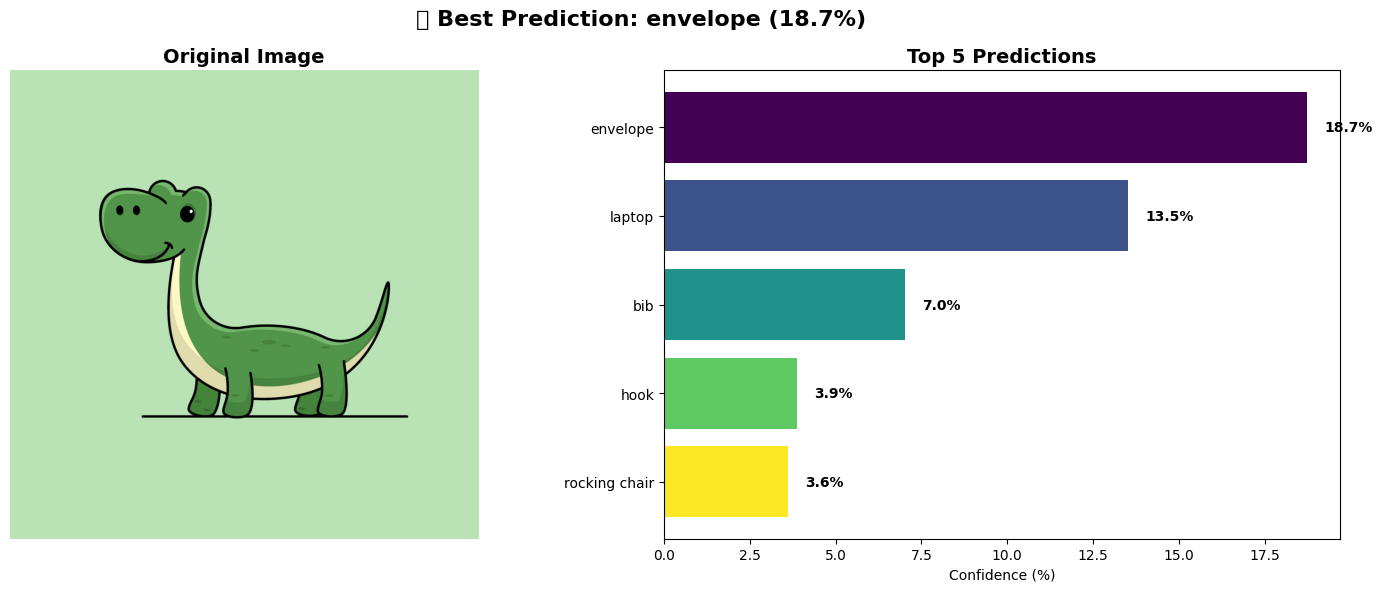


📊 모델 정보:
   🧠 모델: ResNet
   💻 디바이스: cpu
   📋 총 클래스 수: 1000

✅ ImageNet 분류 완료!


{'original_image': <PIL.Image.Image image mode=RGB size=1271x1271>,
 'predictions': [{'rank': 1,
   'class_index': 549,
   'class_name': 'envelope',
   'probability': 0.18741002678871155,
   'percentage': 18.741002678871155},
  {'rank': 2,
   'class_index': 620,
   'class_name': 'laptop',
   'probability': 0.13520129024982452,
   'percentage': 13.520129024982452},
  {'rank': 3,
   'class_index': 443,
   'class_name': 'bib',
   'probability': 0.07020751386880875,
   'percentage': 7.020751386880875},
  {'rank': 4,
   'class_index': 600,
   'class_name': 'hook',
   'probability': 0.038706254214048386,
   'percentage': 3.8706254214048386},
  {'rank': 5,
   'class_index': 765,
   'class_name': 'rocking chair',
   'probability': 0.03602578118443489,
   'percentage': 3.602578118443489},
  {'rank': 6,
   'class_index': 610,
   'class_name': 'jersey',
   'probability': 0.03395504504442215,
   'percentage': 3.395504504442215},
  {'rank': 7,
   'class_index': 520,
   'class_name': 'crib',
   'pro

In [7]:
# =============================================================================
# 메인 실행 부분
# =============================================================================

print("🎯 ImageNet 1000개 클래스 분류기 실행 옵션:")
print("1. 단일 이미지 분류: classify_uploaded_image()")
print("2. 다중 모델 비교: compare_multiple_models()")
print("3. 여러 이미지 일괄 분류: batch_classify()")
print("\n💡 추천: classify_uploaded_image() 로 시작하세요!")
print("\n🧠 사용 가능한 모델: ResNet50, VGG16, EfficientNet, MobileNet 등")
print("📊 분류 가능: 동물, 차량, 음식, 도구, 자연물 등 1000개 카테고리")
print("\n⚡ 준비 완료! 업로드 전용 ImageNet 분류기입니다!")

# 사용자가 직접 함수 호출
classify_uploaded_image()